# PINN-based Parameter Inversion for Microbeam Resonators

---

## 1.1 数据加载与结构说明

本节完成用于 $(w\_t, l\_t)$ 反演任务的主数据集加载，并明确每个字段的存储结构，为后续特征工程和神经网络训练打下基础。

### **数据读取方式**

* 数据集已以 HDF5 (`wt_lt.h5`) 格式存储，主表为 `'data_valid'`，通过 `pandas` 统一读取，确保索引与字段信息可溯源。
* 所有物理常数、采样点坐标等全局信息，均可通过 `attrs.constants` 直接加载。

### **主数据结构说明**

每一行为一组 $(w\_t, l\_t)$ 参数下的有效物理响应，字段包括：

* `w_t`, `l_t` ：当前样本的梁宽、梁长（目标反演参数，单位：米）
* `freq`, `m_c` ：剔除无效 nan 后的频率/电流响应（均为 ndarray，长度为有效区间长度，float32）
* `phi` ：对应响应的采样角度点（有效区间，单位：弧度，ndarray）
* `freq_min`, `freq_max`, `freq_center` ：本组样本 freq 的最小值、最大值、$\phi=90^\circ$ 处中心点值
* `m_c_min`, `m_c_max`, `m_c_center` ：同理，电流响应的最小、最大、中心点
* （如有需要，可扩展其它物理特征/统计量）

### **下游数据拆分和结构组织**

* 加载后，分别提取每个通道的有效输入 (`freq`, `m_c`)，以及所有统计量，转换为 list/array 格式。
* 按照 8:2 划分训练集和测试集，保证网络泛化评估公正。

---



## 自适应归一化处理与特征设计

在本部分，我们针对每个 $(w\_t, l\_t)$ 样本的输入特征分别设计了物理合理且网络友好的归一化方案，并在数据集字段中提前计算保存，便于后续灵活调用和逆归一化。

### **1. freq 的归一化方法（以中心点为参考，幅度归一化）**

对于每个样本的频率响应曲线 $\mathrm{freq}(\phi)$，我们定义其中心点为 $\phi=90^\circ$ 处的取值 $\mathrm{freq}\_{\text{center}}$，并利用样本内最大、最小值进行幅度归一化：

$$
\boxed{
\mathrm{freq}_{\mathrm{norm}}(\phi) = \frac{\mathrm{freq}(\phi) - \mathrm{freq}_{\text{center}}}{\mathrm{freq}_{\max} - \mathrm{freq}_{\min}}
}
$$

* $\mathrm{freq}\_{\text{center}}$ ：当前样本 $\phi=90^\circ$ 处的频率值（已在数据生成阶段提取）
* $\mathrm{freq}*{\max}, \mathrm{freq}*{\min}$：当前样本在有效区间内的最大、最小频率

该归一化方式使得输入曲线在中心点归一为0，其它点反映其**相对变化幅度**，既消除了跨样本的绝对量级影响，又保留了物理结构的全局差异。

---

### **2. $m\_c$ 的归一化方法（min-max归一化）**

对于每个样本的 motional current 响应曲线 $m\_c(\phi)$，采用标准 min-max 归一化：

$$
\boxed{
m_{c,\mathrm{norm}}(\phi) = \frac{m_c(\phi) - m_{c,\min}}{m_{c,\max} - m_{c,\min}}
}
$$

* $m\_{c,\max}, m\_{c,\min}$：当前样本有效区间内 $m\_c$ 的最大、最小值

此方法保证归一化后的 $m\_c$ 分布在 $[0, 1]$ 区间内，非常适合神经网络建模和激活函数处理，也能很好刻画其物理单峰结构。

---

### **3. 中心点信息**

每个样本还会额外记录 $freq_{center}, m\_{c}_{center}$，作为特征直接输入模型，为网络提供绝对量级的先验。

---

### **4. 输出参数独立归一化**

目标参数 $w\_t$ 和 $l\_t$ 采用独立的 `StandardScaler` 归一化，保证反归一化和物理量还原的准确性。

---

### **归一化处理总结**

* **输入：** 对每个样本，拼接 $[\mathrm{freq}*{\mathrm{norm}}, m*{c,\mathrm{norm}}]$ 作为主序列特征，$[\mathrm{freq}*{\text{center}}, m*{c,\text{center}}]$ 作为辅助特征。
* **输出：** $w\_t, l\_t$ 分别独立归一化，便于后续恢复真实物理量。
* **优势：** 极大提升了数据的可比性、网络训练的稳定性，以及模型泛化能力。





In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==== 1.1 数据读取 ====
with pd.HDFStore('./data/wt_lt.h5', 'r') as store:
    df = store['data_valid']  # 已处理好无nan的data_valid，含新统计字段
    constants = store.get_storer('data').attrs.constants
    phi_full = np.array(constants['phi'])

print(f"已载入有效数据集，总样本数: {len(df)}")
print("数据集常数参数:", list(constants.keys()))

# ==== 1.2 构建输入X和输出Y ====
X_freq   = df['freq'].apply(lambda x: np.array(x, dtype=np.float32)).tolist()
X_mc     = df['m_c'].apply(lambda x: np.array(x, dtype=np.float32)).tolist()
phi_list = df['phi'].apply(lambda x: np.array(x, dtype=np.float32)).tolist()
freq_min    = df['freq_min'].values
freq_max    = df['freq_max'].values
freq_center = df['freq_center'].values
mc_min      = df['m_c_min'].values
mc_max      = df['m_c_max'].values
mc_center   = df['m_c_center'].values
Y_wt = df['w_t'].values.astype(np.float32).reshape(-1, 1)
Y_lt = df['l_t'].values.astype(np.float32).reshape(-1, 1)


# 只需要你后续 loss 计算用到的字段
param_keys = ['m_coef_b', 'k_coef_b', 'k_coef_b3', 'k_tt', 'k_t3', 'Mass',
              'omega_0', 'freq_0', 'trans_factor', 'k_e', 'k_e3']
param_dict_list = []
for i, row in df.iterrows():
    param = {k: row[k] for k in param_keys}
    param_dict_list.append(param)

# ==== 1.3 划分训练集和测试集 ====
idx = np.arange(len(X_freq))
idx_tr, idx_te = train_test_split(idx, test_size=0.2, random_state=42)
def select_list(lst, idx): return [lst[i] for i in idx]
def select_arr(arr, idx): return arr[idx]

X_freq_tr, X_mc_tr, phi_tr = select_list(X_freq, idx_tr), select_list(X_mc, idx_tr), select_list(phi_list, idx_tr)
X_freq_te, X_mc_te, phi_te = select_list(X_freq, idx_te), select_list(X_mc, idx_te), select_list(phi_list, idx_te)
freq_min_tr, freq_max_tr, freq_center_tr = select_arr(freq_min, idx_tr), select_arr(freq_max, idx_tr), select_arr(freq_center, idx_tr)
mc_min_tr, mc_max_tr, mc_center_tr = select_arr(mc_min, idx_tr), select_arr(mc_max, idx_tr), select_arr(mc_center, idx_tr)
freq_min_te, freq_max_te, freq_center_te = select_arr(freq_min, idx_te), select_arr(freq_max, idx_te), select_arr(freq_center, idx_te)
mc_min_te, mc_max_te, mc_center_te = select_arr(mc_min, idx_te), select_arr(mc_max, idx_te), select_arr(mc_center, idx_te)
Y_wt_tr, Y_lt_tr = Y_wt[idx_tr], Y_lt[idx_tr]
Y_wt_te, Y_lt_te = Y_wt[idx_te], Y_lt[idx_te]
param_tr = [param_dict_list[i] for i in idx_tr]
param_te = [param_dict_list[i] for i in idx_te]
print(f"训练集: {len(X_freq_tr)}，测试集: {len(X_freq_te)}")

# ==== 1.4 对输出独立归一化 ====
scaler_wt = StandardScaler().fit(Y_wt_tr)
scaler_lt = StandardScaler().fit(Y_lt_tr)
Y_wt_tr = scaler_wt.transform(Y_wt_tr)
Y_wt_te = scaler_wt.transform(Y_wt_te)
Y_lt_tr = scaler_lt.transform(Y_lt_tr)
Y_lt_te = scaler_lt.transform(Y_lt_te)

# ==== 1.5 利用统计字段做归一化 ====
def freq_norm_custom(x, center, minval, maxval):
    return (x - center) / (maxval - minval + 1e-9)

def mc_minmax_norm(x, minval, maxval):
    return (x - minval) / (maxval - minval + 1e-9)


Xtr_seq, Xtr_center = [], []
for freq, mc, fmin, fmax, fcenter, mmin, mmax, mcenter in zip(
        X_freq_tr, X_mc_tr, freq_min_tr, freq_max_tr, freq_center_tr,
        mc_min_tr, mc_max_tr, mc_center_tr):
    freq_normed = freq_norm_custom(freq, fcenter, fmin, fmax)
    mc_normed   = mc_minmax_norm(mc, mmin, mmax)
    x_seq = np.stack([freq_normed, mc_normed], axis=1)
    x_center = np.array([fcenter, mcenter], dtype=np.float32)
    Xtr_seq.append(x_seq)
    Xtr_center.append(x_center)

Xte_seq, Xte_center = [], []
for freq, mc, fmin, fmax, fcenter, mmin, mmax, mcenter in zip(
        X_freq_te, X_mc_te, freq_min_te, freq_max_te, freq_center_te,
        mc_min_te, mc_max_te, mc_center_te):
    freq_normed = freq_norm_custom(freq, fcenter, fmin, fmax)
    mc_normed   = mc_minmax_norm(mc, mmin, mmax)
    x_seq = np.stack([freq_normed, mc_normed], axis=1)
    x_center = np.array([fcenter, mcenter], dtype=np.float32)
    Xte_seq.append(x_seq)
    Xte_center.append(x_center)


print(f"样本输入（归一化序列）长度范围: {min([x.shape[0] for x in Xtr_seq])}~{max([x.shape[0] for x in Xtr_seq])}")
print(f"样本中心点 shape: {Xtr_center[0].shape}")

# ==== 1.6 保存scaler ====
import joblib
joblib.dump([scaler_wt, scaler_lt], './data/standard_scalers_wtlt_indep.pkl')


print('\n==== 训练集物理参数 param_tr 结构 ====')
print('字段名称:', list(param_tr[0].keys()))
print('总样本数:', len(param_tr))

# 随机抽取3个样本，展示对应wt, lt及全部物理参数
import random
sample_indices = random.sample(range(len(param_tr)), min(3, len(param_tr)))
for idx in sample_indices:
    print(f"\nSample idx: {idx}")
    print(f"  w_t: {Y_wt_tr[idx,0]:.6f} (归一化后), l_t: {Y_lt_tr[idx,0]:.6f} (归一化后)")
    print("  物理参数：")
    for k, v in param_tr[idx].items():
        print(f"    {k}: {v}")

print("\n数据加载与自适应归一化（min-max/center）已完成。训练集与测试集已准备好。")





已载入有效数据集，总样本数: 268
数据集常数参数: ['E', 'rho', 't', 'eps_0', 'beta', 'alpha_n', 'V', 'd', 'electrode_length', 'electrode_width', 'w_c', 'l_c', 'Vac_ground', 'Q', 'phi', 'number_of_sim']
训练集: 214，测试集: 54
样本输入（归一化序列）长度范围: 129~161
样本中心点 shape: (2,)

==== 训练集物理参数 param_tr 结构 ====
字段名称: ['m_coef_b', 'k_coef_b', 'k_coef_b3', 'k_tt', 'k_t3', 'Mass', 'omega_0', 'freq_0', 'trans_factor', 'k_e', 'k_e3']
总样本数: 214

Sample idx: 151
  w_t: -0.464889 (归一化后), l_t: 1.177163 (归一化后)
  物理参数：
    m_coef_b: 0.39648133553019954
    k_coef_b: 198.45089151847685
    k_coef_b3: 12.564204922771605
    k_tt: 95.84533798188907
    k_t3: 728172370352.6755
    Mass: 1.0466553401517073e-09
    omega_0: 302610.2607670458
    freq_0: 48161.91883140278
    trans_factor: 2.1510416666666667e-08
    k_e: 0.03585069444444444
    k_e3: 1991705246.9135802

Sample idx: 61
  w_t: -1.105359 (归一化后), l_t: 1.563236 (归一化后)
  物理参数：
    m_coef_b: 0.3964813355301996
    k_coef_b: 198.45089151847674
    k_coef_b3: 12.564204922771605
    k_tt

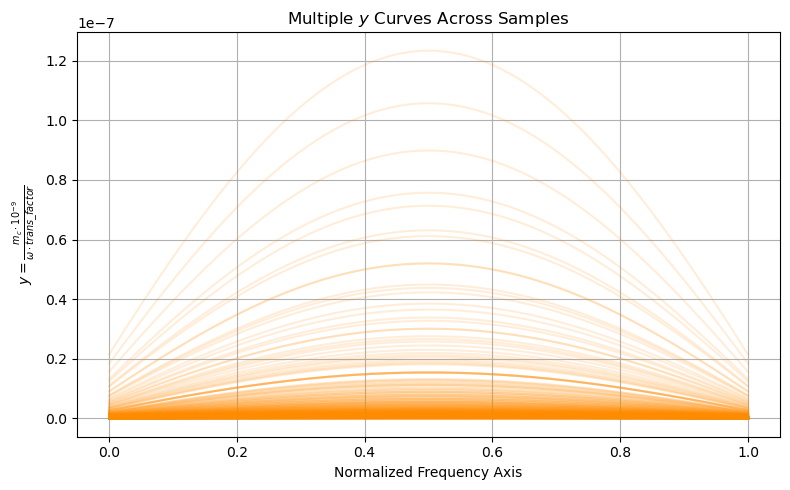

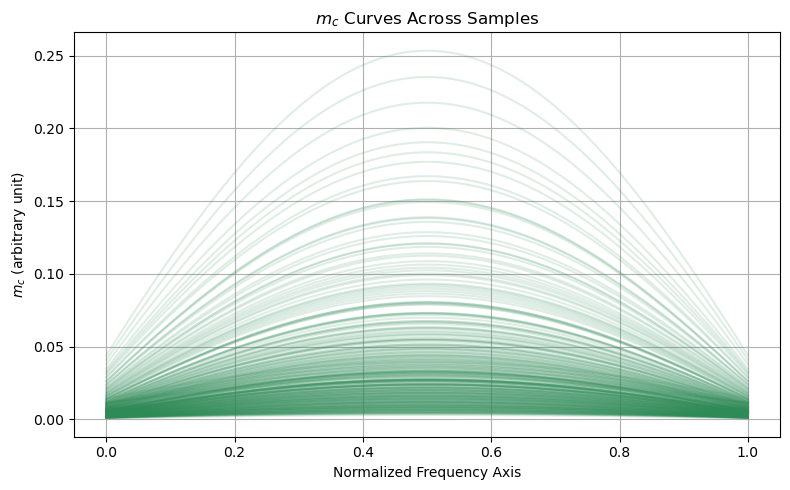

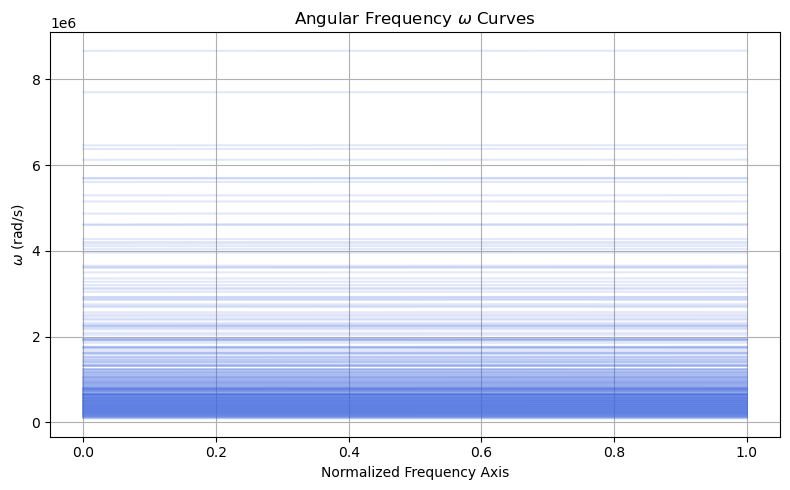

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for freq, m_c, param in zip(X_freq, X_mc, param_dict_list):
    omega = 2 * np.pi * np.array(freq)  # freq 单位: Hz，转换为 rad/s
    trans_factor = param['trans_factor']
    y = np.array(m_c) * 1e-9 / (omega * trans_factor)
    # 归一化横坐标为 [0, 1]
    x_norm = np.linspace(0, 1, len(freq))
    # 绘图
    plt.plot(x_norm, y, color='darkorange', alpha=0.15)

plt.xlabel('Normalized Frequency Axis')
plt.ylabel(r'$y = \frac{m_c \cdot 10^{-9}}{\omega \cdot trans\_factor}$')
plt.title('Multiple $y$ Curves Across Samples')
plt.grid(True)
plt.tight_layout()
plt.savefig('./viz/y_curves.png', dpi=300)
plt.show()


# 画 m_c 曲线图
plt.figure(figsize=(8, 5))
for m_c in X_mc:
    m_c = np.array(m_c)
    x_norm = np.linspace(0, 1, len(m_c))
    plt.plot(x_norm, m_c, color='seagreen', alpha=0.15)
plt.xlabel('Normalized Frequency Axis')
plt.ylabel(r'$m_c$ (arbitrary unit)')
plt.title('$m_c$ Curves Across Samples')
plt.grid(True)
plt.tight_layout()
plt.savefig('./viz/mc_curves.png', dpi=300)
plt.show()


# 画 omega 曲线图
plt.figure(figsize=(8, 5))
for freq in X_freq:
    omega = 2 * np.pi * np.array(freq)
    x_norm = np.linspace(0, 1, len(freq))
    plt.plot(x_norm, omega, color='royalblue', alpha=0.15)
plt.xlabel('Normalized Frequency Axis')
plt.ylabel(r'$\omega$ (rad/s)')
plt.title('Angular Frequency $\omega$ Curves')
plt.grid(True)
plt.tight_layout()
plt.savefig('./viz/omega_curves.png', dpi=300)
plt.show()



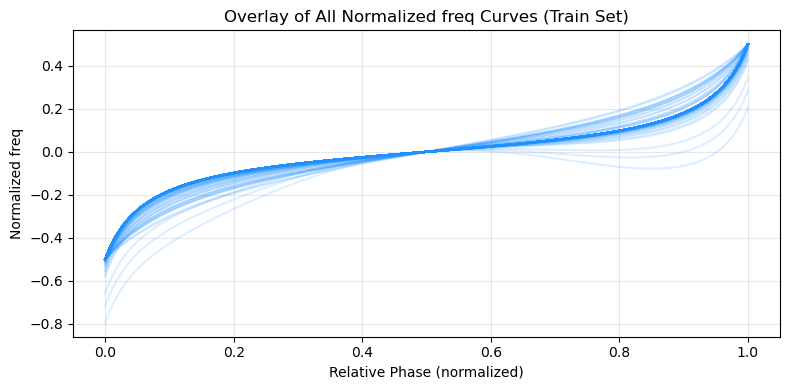

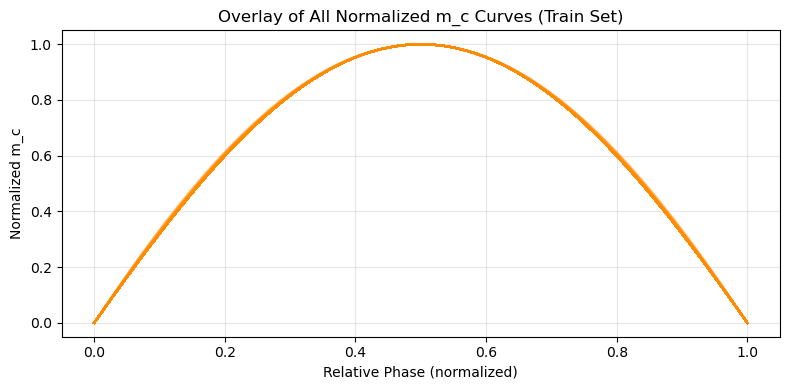

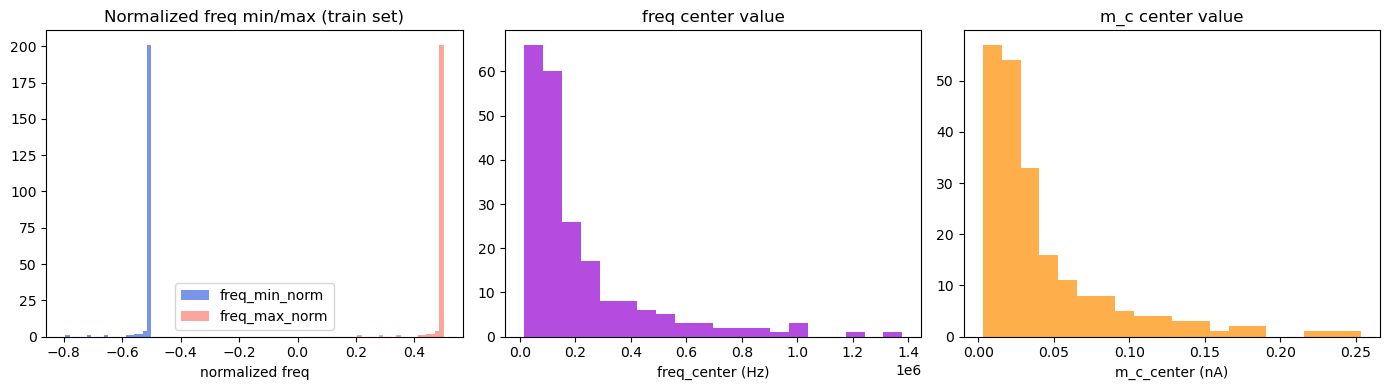

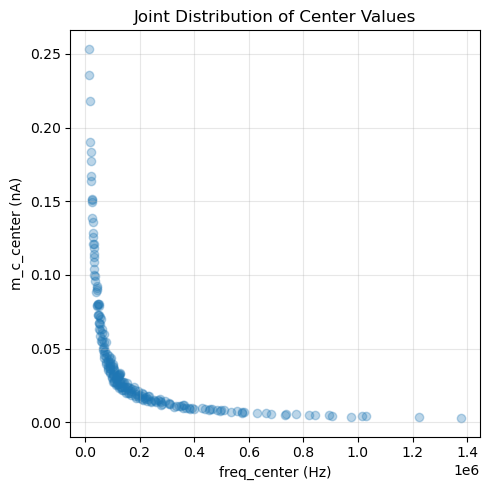

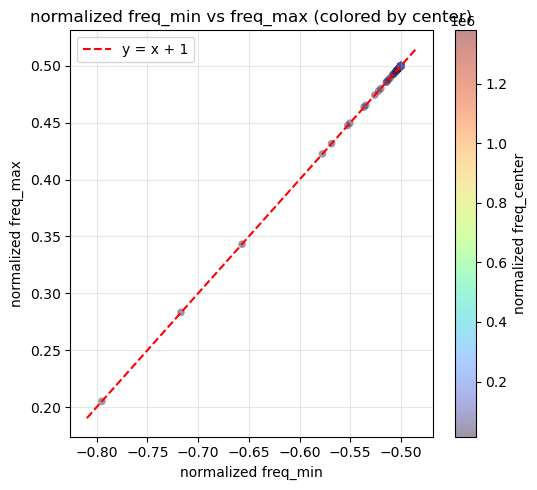

In [ ]:
# ==== 1.7 可视化有效长度分布 ====
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for x in Xtr_seq:
    plt.plot(np.linspace(0, 1, len(x)), x[:, 0], color='dodgerblue', alpha=0.15)
plt.xlabel('Relative Phase (normalized)')
plt.ylabel('Normalized freq')
plt.title('Overlay of All Normalized freq Curves (Train Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('viz/overlay_normed_freq.png', dpi=150)
plt.show()

plt.figure(figsize=(8, 4))
for x in Xtr_seq:
    plt.plot(np.linspace(0, 1, len(x)), x[:, 1], color='darkorange', alpha=0.15)
plt.xlabel('Relative Phase (normalized)')
plt.ylabel('Normalized m_c')
plt.title('Overlay of All Normalized m_c Curves (Train Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('viz/overlay_normed_mc.png', dpi=150)
plt.show()



freq_centers = np.array([c[0] for c in Xtr_center])
mc_centers = np.array([c[1] for c in Xtr_center])
freq_mins = freq_min_tr
freq_maxs = freq_max_tr
mc_mins = mc_min_tr
mc_maxs = mc_max_tr
# 统计每个样本归一化后的最小/最大值
freq_mins_norm = np.array([x[:,0].min() for x in Xtr_seq])
freq_maxs_norm = np.array([x[:,0].max() for x in Xtr_seq])


plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(freq_mins_norm, bins=20, alpha=0.7, color='royalblue', label='freq_min_norm')
plt.hist(freq_maxs_norm, bins=20, alpha=0.7, color='salmon', label='freq_max_norm')
plt.xlabel('normalized freq')
plt.title('Normalized freq min/max (train set)')
plt.legend()
plt.tight_layout()


plt.subplot(1,3,2)
plt.hist(freq_centers, bins=20, color='darkviolet', alpha=0.7)
plt.xlabel('freq_center (Hz)')
plt.title('freq center value')

plt.subplot(1,3,3)
plt.hist(mc_centers, bins=20, color='darkorange', alpha=0.7)
plt.xlabel('m_c_center (nA)')
plt.title('m_c center value')
plt.tight_layout()
plt.savefig('viz/normed_minmax_center_hist.png', dpi=150)
plt.show()


plt.figure(figsize=(5,5))
plt.scatter(freq_centers, mc_centers, alpha=0.3)
plt.xlabel('freq_center (Hz)')
plt.ylabel('m_c_center (nA)')
plt.title('Joint Distribution of Center Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('viz/joint_center_scatter.png', dpi=150)
plt.show()
plt.figure(figsize=(5.5,5))
sc = plt.scatter(freq_mins_norm, freq_maxs_norm, c=freq_centers, alpha=0.45, cmap='turbo', edgecolor='none', s=30)

# 添加辅助线 y = x+1
xlim = plt.xlim()
ylim = plt.ylim()
x_line = np.linspace(min(xlim[0], ylim[0]-1), max(xlim[1], ylim[1]-1), 100)
plt.plot(x_line, x_line + 1, 'r--', linewidth=1.5, label='y = x + 1')

plt.xlabel('normalized freq_min')
plt.ylabel('normalized freq_max')
plt.title('normalized freq_min vs freq_max (colored by center)')
plt.colorbar(sc, label='normalized freq_center')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('viz/normed_min_vs_max_scatter.png', dpi=150)
plt.show()



## 2. 数据集基本信息与可视化

本节对已加载的频响数据（`freq`, `m_c`）及目标参数（$w\_t$, $l\_t$）进行快速可视化和基本统计分析。
这样可以直观了解数据的样本数、输入输出shape、物理量范围，以及不同样本曲线的变化趋势，有助于后续网络设计和调试。

* 打印样本数和输入输出的形状（变长/均值/区间等）
* 展示`freq`和`m_c`的全数据最小/最大值
* 随机抽取样本，画出对应的`freq`和`m_c`曲线，辅助判断数据分布及物理合理性


Total samples: 214 (train), 54 (test)
Target Y_wt shape: (214, 1), Y_lt shape: (214, 1) (均为独立归一化)
Train: input freq/m_c length in [129, 161], mean: 159.72
Test:  input freq/m_c length in [137, 161], mean: 160.07
归一后（中心点相对值）freq min: -0.795, max: 0.500
归一后（中心点相对值）m_c  min: -0.000, max: 1.000
中心点freq_phi90 min: 1.520e+04, max: 1.379e+06
中心点m_c_phi90 min: 2.868e-03, max: 2.534e-01
w_t  min: 5.000μm, max: 20.000μm
l_t  min: 100.000μm, max: 1000.000μm


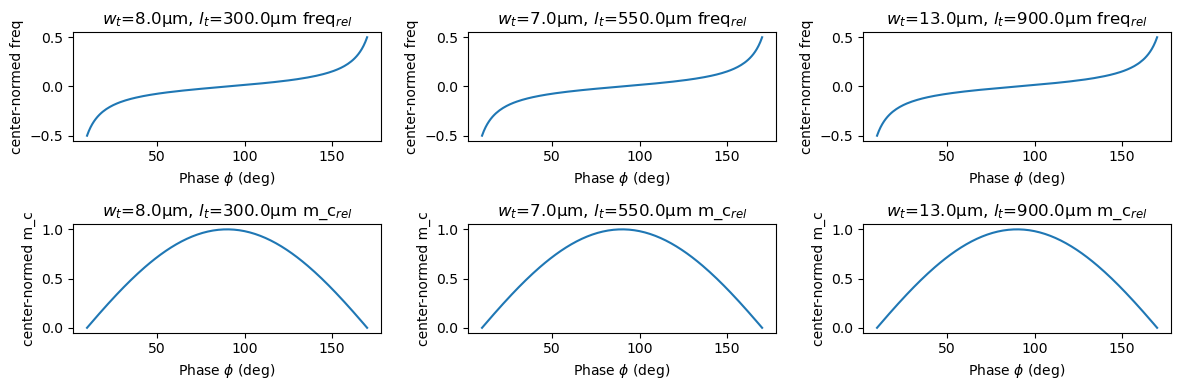

In [47]:
# === 数据基本信息 ===
print(f"Total samples: {len(Xtr_seq)} (train), {len(Xte_seq)} (test)")
print(f"Target Y_wt shape: {Y_wt_tr.shape}, Y_lt shape: {Y_lt_tr.shape} (均为独立归一化)")
train_lengths = [x.shape[0] for x in Xtr_seq]
test_lengths = [x.shape[0] for x in Xte_seq]
print(f"Train: input freq/m_c length in [{min(train_lengths)}, {max(train_lengths)}], mean: {np.mean(train_lengths):.2f}")
print(f"Test:  input freq/m_c length in [{min(test_lengths)}, {max(test_lengths)}], mean: {np.mean(test_lengths):.2f}")

# freq/m_c 全数据全局归一化前数值范围（物理量级，中心点未归一化）
all_freq = np.concatenate([x[:,0] for x in Xtr_seq])
all_mc   = np.concatenate([x[:,1] for x in Xtr_seq])
print(f"归一后（中心点相对值）freq min: {np.nanmin(all_freq):.3f}, max: {np.nanmax(all_freq):.3f}")
print(f"归一后（中心点相对值）m_c  min: {np.nanmin(all_mc):.3f}, max: {np.nanmax(all_mc):.3f}")

# 输出中心点的物理范围（真实物理值，未归一化）
all_f90 = np.array([x[0] for x in Xtr_center])
all_m90 = np.array([x[1] for x in Xtr_center])
print(f"中心点freq_phi90 min: {np.min(all_f90):.3e}, max: {np.max(all_f90):.3e}")
print(f"中心点m_c_phi90 min: {np.min(all_m90):.3e}, max: {np.max(all_m90):.3e}")

# w_t / l_t 的物理量级范围
print(f"w_t  min: {scaler_wt.inverse_transform([[Y_wt_tr.min()]])[0,0]*1e6:.3f}μm, max: {scaler_wt.inverse_transform([[Y_wt_tr.max()]])[0,0]*1e6:.3f}μm")
print(f"l_t  min: {scaler_lt.inverse_transform([[Y_lt_tr.min()]])[0,0]*1e6:.3f}μm, max: {scaler_lt.inverse_transform([[Y_lt_tr.max()]])[0,0]*1e6:.3f}μm")

# === 可视化：随机抽取3个样本画出 freq 和 m_c 归一化后曲线 ===
import matplotlib.pyplot as plt

idxs = np.random.choice(len(Xtr_seq), size=min(3, len(Xtr_seq)), replace=False)
plt.figure(figsize=(12,4))
for i, idx in enumerate(idxs):
    phi_deg = phi_tr[idx] * 180 / np.pi  # phitr为每个样本的有效phi区间
    plt.subplot(2,3,i+1)
    plt.plot(phi_deg, Xtr_seq[idx][:,0])
    plt.title(f"$w_t$={scaler_wt.inverse_transform([[Y_wt_tr[idx,0]]])[0,0]*1e6:.1f}μm, $l_t$={scaler_lt.inverse_transform([[Y_lt_tr[idx,0]]])[0,0]*1e6:.1f}μm freq$_{{rel}}$")
    plt.xlabel('Phase $\phi$ (deg)')
    plt.ylabel('center-normed freq')
    plt.subplot(2,3,i+4)
    plt.plot(phi_deg, Xtr_seq[idx][:,1])
    plt.title(f"$w_t$={scaler_wt.inverse_transform([[Y_wt_tr[idx,0]]])[0,0]*1e6:.1f}μm, $l_t$={scaler_lt.inverse_transform([[Y_lt_tr[idx,0]]])[0,0]*1e6:.1f}μm m_c$_{{rel}}$")
    plt.xlabel('Phase $\phi$ (deg)')
    plt.ylabel('center-normed m_c')
plt.tight_layout()
plt.savefig('viz/normed_mc_freq_examples', dpi=150)
plt.show()


## 3. 网络结构定义

由于本任务的输入为**变长的多通道归一化时序序列**（每个样本 $L_i \in [128, 161]$，通道为 [freq, m_c]），  
且目标为结构参数 $(w_t, l_t)$ 的联合反演，传统的定长1D-CNN不再适用。为此，我们采用适合变长输入的神经网络架构。

### 网络结构设计思路

- **输入层**  
  每个样本输入为 shape $[L_i, 2]$ 的归一化 (freq, m_c) 时序数据，同时引入 $[2,]$ 的中心点物理特征 $[\mathrm{freq}_{center}, m_{c,center}]$ 作为辅助输入。

- **特征编码器**  
  主干采用**Transformer Encoder**（或 LSTM/GRU 等循环结构），
  能够自动对变长的物理响应序列进行全局和局部特征建模，适配变长输入与时序信息。

- **全局池化**  
  利用全局自适应池化（如均值池化或最后token），将变长时序特征压缩为定长向量。

- **辅助特征拼接**  
  池化后的时序特征与中心点物理特征拼接，增强模型的物理量级感知能力。

- **输出头**  
  采用MLP回归输出，将融合后的高维特征映射为目标参数 $(w_t, l_t)$。

#### 结构示意

- 输入: $[L_i, 2]$（归一化freq, m_c序列）+ $[2,]$（中心点特征）
- 主干: Transformer Encoder（或LSTM/GRU）
- 池化: 全局平均池化或取最后token
- 拼接: 加入中心点特征
- 输出: MLP回归，预测$(w_t, l_t)$


In [48]:
import torch
import torch.nn as nn

class SequenceToParamsNet(nn.Module):
    """
    适用于wt/lt参数反演任务的Transformer网络结构。
    - 输入: 变长 [B, L, 2] 归一化频谱序列, [B, 2] 中心点特征
    - 输出: [B, 2]，为分别标准化后的wt, lt（建议用StandardScaler）
    """
    def __init__(self, d_input=2, d_model=32, nhead=4, num_layers=2, d_ff=64, out_dim=2):
        super().__init__()
        # 线性升维
        self.input_proj = nn.Linear(d_input, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_ff, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.out_head = nn.Sequential(
            nn.Linear(d_model + 2, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )


    def forward(self, x_seq, x_center, mask=None):
        # x_seq: [B, L, 2], x_center: [B, 2]
        h = self.input_proj(x_seq)    # [B, L, d_model]
        h = self.encoder(h, src_key_padding_mask=mask)   # [B, L, d_model]
        h = h.transpose(1,2)          # [B, d_model, L]
        h = self.pool(h).squeeze(-1)  # [B, d_model]
        hcat = torch.cat([h, x_center], dim=-1)   # [B, d_model+2]
        y_pred = self.out_head(hcat)  # [B, 2]
        # 不加激活函数，直接输出归一化值
        return y_pred


## 4. PINN物理损失设计（数据loss+PDE残差，PINNsformer架构）

本节结合监督数据损失与微梁动力学PDE残差项，实现物理引导神经网络（PINN/Physics-Informed Transformer，PINNsformer）结构，  
以充分利用时序响应物理规律，提高 $(w_t, l_t)$ 反演精度与物理一致性。

---

### 4.1 数据监督损失（Data Loss）

以神经网络输出的 $(w_t, l_t)$ 预测值与真实标签的均方误差（MSE）为主监督项：

$$
\mathcal{L}_{data} = \frac{1}{N} \sum_{i=1}^N \left[ (w_{t,pred}^{(i)} - w_{t,true}^{(i)})^2 + (l_{t,pred}^{(i)} - l_{t,true}^{(i)})^2 \right]
$$

---

### 4.2 PDE主方程残差损失（PDE Residual Loss）

本项利用神经网络反演得到的 $(w_t, l_t)$，结合每个样本自身的响应曲线（freq, m_c, $\phi$）和物理常数，  
将网络预测参数动态带入动力学主方程，对每个时序采样点计算物理残差作为损失。

#### 动力学主方程

微梁动力学系统由如下非线性代数方程描述：

$$
\begin{cases}
- M \omega^2 y + (k_t - k_e) y + (k_{t3} - k_{e3}) \dfrac{3}{4} y^3 - F_{ac} \cos(\phi) = 0 \\
c \omega y - F_{ac} \sin(\phi) = 0
\end{cases}
$$

- **参数说明：**
  - $M, k_t, k_{t3}$ 等刚度/质量等参数，需根据网络预测的 $w_t, l_t$ 以及其它常数动态计算，具体见“参数公式表”。
  - 其它常数如 $V, d, \text{electrode\_length}$ 等直接从数据集常数字段获取。

- $\omega = 2\pi \cdot \mathrm{freq}$：频率响应点
- $y$：通过 $m_c$ 反推的幅值
- $\phi$：输入相位

#### PDE残差定义

每个样本的 $(w_t, l_t)$ 预测值带入对应物理方程，遍历该样本所有有效 $\phi$ 采样点，  
分别计算两个主方程残差 $R_1, R_2$，并取全时序均方和为物理残差损失：

$$
\mathcal{L}_{pde} = \frac{1}{N} \sum_{i=1}^N \frac{1}{T_i} \sum_{t=1}^{T_i} \left[ (R_1^{(i,t)})^2 + (R_2^{(i,t)})^2 \right]
$$
- $T_i$：第 $i$ 个样本有效时序长度（变长输入可用mask规避padding点）

---

### 4.3 PINNsformer物理引导总损失

最终总损失为数据损失与物理残差的加权和：

$$
\mathcal{L}_{total} = \lambda_{data} \cdot \mathcal{L}_{data} + \lambda_{pde} \cdot \mathcal{L}_{pde}
$$

其中 $\lambda_{data}, \lambda_{pde}$ 为可调权重超参数。

---

> 通过上述混合损失，神经网络可同时学习数据拟合能力与物理一致性，实现结构参数 $(w_t, l_t)$ 的高精度、强泛化物理反演。


In [49]:
import torch
import torch.nn.functional as F

def data_loss(y_pred, y_true):
    """
    y_pred, y_true: [B, 2]，分别为网络输出/真实的 [w_t, l_t]（已归一化或原始物理量，根据你的设置）
    """
    return F.mse_loss(y_pred, y_true)


### 4.2 PDE主方程残差损失（PDE Residual Loss）

本损失项利用每个样本独有的物理参数、网络反演得到的 $(w_t, l_t)$、输入响应曲线（freq, m_c, $\phi$），  
将网络输出动态带入主动力学方程，对所有有效采样点计算残差。

#### 计算流程说明

- **输入**：
  - 网络预测的 $w_t, l_t$（归一化，需反归一化还原物理单位）
  - 每个样本的时序输入（freq, m_c, $\phi$）
  - 局部物理参数（如 $m_\mathrm{coef\_b}$, $k_{tt}$, $Mass$, $k_e$, ...），由$(w_t, l_t)$决定并预存于数据集
  - 全局常数（如 $V$, $Q$, $Vac_{ground}$ 等）
- **步骤**：
  1. 逐个样本，用网络预测的 $w_t, l_t$ 反归一化为物理量
  2. 结合局部物理参数、全局常数、输入响应曲线，带入主动力学方程，计算每个采样点的物理残差 $R_1, R_2$
  3. 对所有有效采样点残差求均方和，得到该样本的物理损失
  4. 全batch平均，得PDE总物理残差loss

#### 数学表达式

$$
\begin{align*}
R_1 &= - M \omega^2 y + (k_t - k_e) y + (k_{t3} - k_{e3}) \frac{3}{4} y^3 - F_{ac} \cos(\phi) \\
R_2 &= c \omega y - F_{ac} \sin(\phi)
\end{align*}
$$

PDE物理损失为：
$$
\mathcal{L}_{pde} = \frac{1}{N} \sum_{i=1}^N \frac{1}{T_i} \sum_{t=1}^{T_i} \left[ (R_1^{(i,t)})^2 + (R_2^{(i,t)})^2 \right]
$$

- $N$：batch内样本数
- $T_i$：第 $i$ 个样本有效采样点数

> 该损失实现网络预测参数与输入物理响应、结构参数的物理一致性约束，有效提升反演准确率和可物理解释性。


In [ ]:
import torch

def pde_residual_loss(
    w_t_pred, l_t_pred, freq, m_c, phi, param_list, constants, scaler_wt, scaler_lt
):
    """
    计算PINN PDE物理残差loss（适配list-of-dict参数结构）
    - w_t_pred, l_t_pred: [B, 1] (归一化后, torch tensor)
    - freq, m_c, phi: list of [L_i,] (torch tensor, 每个样本有效长度)
    - param_list: list of dict，局部物理参数
    - constants: 全局常数 dict
    - scaler_wt, scaler_lt: 归一化对象
    """
    device = w_t_pred.device
    B = len(freq)
    loss = 0.0

    # 反归一化
    w_t = scaler_wt.inverse_transform(w_t_pred.detach().cpu().numpy()).squeeze(-1)
    l_t = scaler_lt.inverse_transform(l_t_pred.detach().cpu().numpy()).squeeze(-1)

    for i in range(B):
        # 取该样本所有物理参数
        p = param_list[i]
        # 全局常量
        V = constants['V']
        Vac_ground = constants['Vac_ground']
        Q = constants['Q']

        # 梁/系统参数
        m_coef_b   = p['m_coef_b']
        k_coef_b   = p['k_coef_b']
        k_coef_b3  = p['k_coef_b3']
        k_tt       = p['k_tt']
        k_t3       = p['k_t3']
        Mass       = p['Mass']
        trans_factor = p['trans_factor']
        k_e        = p['k_e']
        k_e3       = p['k_e3']

        freq_i = torch.tensor(freq[i], device=device, dtype=torch.float32)
        m_c_i = torch.tensor(m_c[i], device=device, dtype=torch.float32)
        phi_i = torch.tensor(phi[i], device=device, dtype=torch.float32)

        # 动力学相关参数
        omega = 2 * torch.pi * freq_i   # [L]
        # y幅值反推（根据你的实际物理模型写！此处为例）
        y = m_c_i / (omega * trans_factor * 1e-9 + 1e-9)  # [L]
        # 残差
        R1 = -Mass * omega**2 * y + (k_tt - k_e) * y + (k_t3 - k_e3) * (y ** 3) * 3 / 4 - Vac_ground * trans_factor * torch.cos(phi_i)
        c = torch.sqrt(torch.tensor(Mass * k_tt)) / Q
        R2 = c * omega * y - Vac_ground * trans_factor * torch.sin(phi_i)
        # 该样本所有有效点残差loss
        sample_loss = (R1**2 + R2**2).mean()
        loss += sample_loss

    loss = loss / B
    return loss


### 4.4 总损失函数定义（Total Loss）

PINNs物理反演的总损失由**数据监督损失**和**PDE主方程物理残差损失**加权叠加而成：

$$
\mathcal{L}_{total} = \lambda_{data} \cdot \mathcal{L}_{data} + \lambda_{pde} \cdot \mathcal{L}_{pde}
$$

- $\mathcal{L}_{data}$：网络输出与标签的MSE监督损失
- $\mathcal{L}_{pde}$：物理主方程残差损失
- $\lambda_{data}, \lambda_{pde}$：可调权重

此结构可兼顾数据拟合能力与物理一致性，实现高物理可信度与泛化能力的结构参数反演。


In [51]:
def total_loss(
    y_pred, y_true,         # 网络输出和标签，shape: [B, 2]
    freq, m_c, phi,         # 输入时序（list，长度B，每个为[L_i,]）
    param_list, constants,  # 每个样本的局部物理参数、全局常数
    scaler_wt, scaler_lt,   # 反归一化工具
    lambda_data=1.0, lambda_pde=0
):
    """
    计算PINN物理反演总损失
    - y_pred: 网络输出 [B, 2]（归一化），即 (w_t_pred, l_t_pred)
    - y_true: 标签 [B, 2]（归一化），即 (w_t_true, l_t_true)
    - freq, m_c, phi: list of [L_i,]
    - param_list: list of dict
    - constants: 全局常数
    - scaler_wt, scaler_lt: 归一化对象
    - lambda_data, lambda_pde: 权重
    返回: 总损失, 以及各分量字典
    """
    # 数据loss（可直接用MSE）
    data_loss = torch.nn.functional.mse_loss(y_pred, y_true)
    # 拆分两个输出
    w_t_pred, l_t_pred = y_pred[:, 0:1], y_pred[:, 1:2]
    # PDE物理残差loss
    if lambda_pde > 0:
        w_t_pred, l_t_pred = y_pred[:, 0:1], y_pred[:, 1:2]
        pde_loss = pde_residual_loss(
            w_t_pred, l_t_pred, freq, m_c, phi, param_list, constants, scaler_wt, scaler_lt
        )
    else:
        pde_loss = torch.tensor(0.0, device=y_pred.device)
    loss = lambda_data * data_loss + lambda_pde * pde_loss
    return loss, {'data_loss': data_loss.item(), 'pde_loss': pde_loss.item()}


### 4.x 初值/边界损失（Initial/Boundary Loss，保留待实现）

在物理信息神经网络（PINN）中，初值损失与边界损失通常用于强化模型在时序两端的物理约束，具体形式如下：

#### 初值损失（Initial Condition Loss）

通常写作：
$$
\mathcal{L}_{\text{init}} = \frac{1}{N} \sum_{i=1}^N \left( f_{\text{NN}}(\phi_0^{(i)}) - f_{\text{theory}}(\phi_0^{(i)}) \right)^2
$$
其中：
- $f_{\text{NN}}(\phi_0^{(i)})$ 为神经网络在序列起点 $\phi_0$ 的输出
- $f_{\text{theory}}(\phi_0^{(i)})$ 为理论/观测或物理边界的已知值

#### 边界损失（Boundary Condition Loss）

通常写作：
$$
\mathcal{L}_{\text{boundary}} = \frac{1}{N} \sum_{i=1}^N \left( f_{\text{NN}}(\phi_T^{(i)}) - f_{\text{theory}}(\phi_T^{(i)}) \right)^2
$$
其中：
- $\phi_T$ 为序列终点
- 其他符号同上

#### 在本参数反演任务中的当前情况

本任务中，神经网络的输出为全局参数 $Q$，输入为观测到的序列（freq, m_c）。  
由于网络直接预测的是参数 $Q$，而不是序列本身，因此只有在能由 $Q$ 及常数、输入等反推出起点/终点理论物理量的情况下，  
才能通过如下方式定义初/边值损失：

$$
\mathcal{L}_{\text{init/boundary}} = \frac{1}{N} \sum_{i=1}^N \left( f_{\text{theory}}(\phi_0^{(i)}, Q^{(i)}) - f_{\text{obs}}(\phi_0^{(i)}) \right)^2 + \left( f_{\text{theory}}(\phi_T^{(i)}, Q^{(i)}) - f_{\text{obs}}(\phi_T^{(i)}) \right)^2
$$

- $f_{\text{theory}}$ 表示由网络反演参数 $Q$、常数与输入推算得到的理论边界值
- $f_{\text{obs}}$ 为真实观测边界数据

**若后续获得解析解或理论边界表达式，可据此添加该loss项实现。当前本loss项暂未实现，仅作为结构预留。**


## 5. 训练主循环

每一轮(epoch)训练目标为最小化总损失：

$$
\mathcal{L}_{\text{total}} = \lambda_{\text{data}} \cdot \mathcal{L}_{\text{data}} + \lambda_{\text{pde}} \cdot \mathcal{L}_{\text{pde}}
$$

其中：

- $\mathcal{L}_{\text{data}} = \frac{1}{N} \sum_{i=1}^N (Q_{\text{pred}}^{(i)} - Q_{\text{true}}^{(i)})^2$
- $\mathcal{L}_{\text{pde}} = \frac{1}{N T} \sum_{i=1}^N \sum_{t=1}^T \left( R_1^{(i,t)}{}^2 + R_2^{(i,t)}{}^2 \right)$
- $R_1, R_2$ 为PDE主方程在每个采样点的残差
- $\lambda_{\text{data}}, \lambda_{\text{pde}}$ 为各损失项权重

**训练流程：**
- 对每个epoch，循环遍历batch，前向传播、计算loss、反向传播、参数更新
- 每轮在验证集上评估，记录训练与验证的各项loss
- 验证损失最优时保存模型，连续若干epoch无提升则提前停止（Early Stopping）


In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

# ==== 5.1 自定义Dataset（适配list输入、变长序列）====
class CantileverDataset(Dataset):
    def __init__(self, X_seq, X_center, Y_wt, Y_lt, freq, m_c, phi, param_list):
        self.X_seq = X_seq
        self.X_center = X_center
        self.Y_wt = Y_wt
        self.Y_lt = Y_lt
        self.freq = freq
        self.m_c = m_c
        self.phi = phi
        self.param_list = param_list

    def __len__(self):
        return len(self.X_seq)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X_seq[idx], dtype=torch.float32),      # [L, 2]
            torch.tensor(self.X_center[idx], dtype=torch.float32),   # [2,]
            torch.tensor(np.stack([self.Y_wt[idx], self.Y_lt[idx]]), dtype=torch.float32).squeeze(),
            self.freq[idx], self.m_c[idx], self.phi[idx], self.param_list[idx]
        )

# ==== 5.2 构造DataLoader ====
train_dataset = CantileverDataset(
    Xtr_seq, Xtr_center, Y_wt_tr, Y_lt_tr, X_freq_tr, X_mc_tr, phi_tr, param_tr
)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: list(zip(*batch)))


In [53]:
from tqdm import trange
import torch

def train_model(
    model, Xtr_seq, Xtr_center, Y_wt_tr, Y_lt_tr,
    Xte_seq, Xte_center, Y_wt_te, Y_lt_te,
    epochs=300, lr=1e-3, patience=20, print_interval=20, device='cpu'
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}

    # 构建训练集和测试集索引
    N_tr, N_te = len(Xtr_seq), len(Xte_seq)
    idx_tr = np.arange(N_tr)
    idx_te = np.arange(N_te)

    for epoch in range(epochs):
        model.train()
        train_loss, n_train = 0.0, 0
        # 你可以根据实际批量大小调整
        batch_size = 32
        np.random.shuffle(idx_tr)
        for i in range(0, N_tr, batch_size):
            batch_idx = idx_tr[i:i+batch_size]
            # 构建批次
            x_seq = [torch.tensor(Xtr_seq[j], dtype=torch.float32) for j in batch_idx]
            x_center = torch.tensor([Xtr_center[j] for j in batch_idx], dtype=torch.float32)
            y_true = torch.tensor(np.concatenate([Y_wt_tr[batch_idx], Y_lt_tr[batch_idx]], axis=1), dtype=torch.float32)
            # pad
            x_seq_pad = torch.nn.utils.rnn.pad_sequence(x_seq, batch_first=True, padding_value=0).to(device)
            mask = (torch.sum(x_seq_pad, dim=2) == 0)
            x_center = x_center.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
            y_pred = model(x_seq_pad, x_center, mask)  # [B,2]，输出是标准化后的 $w_t, l_t$
            loss = torch.nn.functional.mse_loss(y_pred, y_true)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_idx)
            n_train += len(batch_idx)
        train_loss /= n_train

        # ---- 验证 ----
        model.eval()
        val_loss, n_val = 0.0, 0
        with torch.no_grad():
            for i in range(0, N_te, batch_size):
                batch_idx = idx_te[i:i+batch_size]
                x_seq = [torch.tensor(Xte_seq[j], dtype=torch.float32) for j in batch_idx]
                x_center = torch.tensor([Xte_center[j] for j in batch_idx], dtype=torch.float32)
                y_true = torch.tensor(np.concatenate([Y_wt_te[batch_idx], Y_lt_te[batch_idx]], axis=1), dtype=torch.float32)
                x_seq_pad = torch.nn.utils.rnn.pad_sequence(x_seq, batch_first=True, padding_value=0).to(device)
                mask = (torch.sum(x_seq_pad, dim=2) == 0)
                x_center = x_center.to(device)
                y_true = y_true.to(device)

                y_pred = model(x_seq_pad, x_center, mask)
                loss = torch.nn.functional.mse_loss(y_pred, y_true)
                val_loss += loss.item() * len(batch_idx)
                n_val += len(batch_idx)
        val_loss /= n_val

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if (epoch+1) % print_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train: {train_loss:.5f} | Val: {val_loss:.5f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "model/wtlt_best.pt")
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch+1}, best val: {best_val_loss:.5f}")
                break

    print("Training finished. Best validation loss:", best_val_loss)
    return history


## 6. 训练模型（模型初始化与训练启动）

- 初始化网络结构（1D-CNN PINN）
- 加载归一化器、常数、DataLoader等
- 启动训练循环，保存最佳模型参数


In [54]:
import torch

# ==== 初始化模型 ====
model = SequenceToParamsNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 300
patience = 20
print_interval = 20

best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

N_tr, N_te = len(Xtr_seq), len(Xte_seq)
idx_tr = np.arange(N_tr)
idx_te = np.arange(N_te)

for epoch in range(epochs):
    model.train()
    train_loss, n_train = 0.0, 0
    batch_size = 32
    np.random.shuffle(idx_tr)
    for i in range(0, N_tr, batch_size):
        batch_idx = idx_tr[i:i+batch_size]
        x_seq = [torch.tensor(Xtr_seq[j], dtype=torch.float32) for j in batch_idx]
        x_center = torch.tensor([Xtr_center[j] for j in batch_idx], dtype=torch.float32)
        y_true = torch.tensor(np.concatenate([Y_wt_tr[batch_idx], Y_lt_tr[batch_idx]], axis=1), dtype=torch.float32)
        x_seq_pad = torch.nn.utils.rnn.pad_sequence(x_seq, batch_first=True, padding_value=0).to(device)
        mask = (torch.sum(x_seq_pad, dim=2) == 0)
        x_center = x_center.to(device)
        y_true = y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_seq_pad, x_center, mask)
        loss = torch.nn.functional.mse_loss(y_pred, y_true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch_idx)
        n_train += len(batch_idx)
    train_loss /= n_train

    # ---- 验证 ----
    model.eval()
    val_loss, n_val = 0.0, 0
    with torch.no_grad():
        for i in range(0, N_te, batch_size):
            batch_idx = idx_te[i:i+batch_size]
            x_seq = [torch.tensor(Xte_seq[j], dtype=torch.float32) for j in batch_idx]
            x_center = torch.tensor([Xte_center[j] for j in batch_idx], dtype=torch.float32)
            y_true = torch.tensor(np.concatenate([Y_wt_te[batch_idx], Y_lt_te[batch_idx]], axis=1), dtype=torch.float32)
            x_seq_pad = torch.nn.utils.rnn.pad_sequence(x_seq, batch_first=True, padding_value=0).to(device)
            mask = (torch.sum(x_seq_pad, dim=2) == 0)
            x_center = x_center.to(device)
            y_true = y_true.to(device)

            y_pred = model(x_seq_pad, x_center, mask)
            loss = torch.nn.functional.mse_loss(y_pred, y_true)
            val_loss += loss.item() * len(batch_idx)
            n_val += len(batch_idx)
    val_loss /= n_val

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if (epoch+1) % print_interval == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.5f} | Val: {val_loss:.5f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "model/wtlt_best.pt")
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch+1}, best val: {best_val_loss:.5f}")
            break

print("Training finished. Best validation loss:", best_val_loss)


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_92093/907987498.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/torch/csrc/utils/tensor_new.cpp:281.)
  x_center = torch.tensor([Xtr_center[j] for j in batch_idx], dtype=torch.float32)


Epoch   1 | Train: 57783977.44860 | Val: 8044924.62963
Epoch  20 | Train: 95.22003 | Val: 10.02670
Epoch  40 | Train: 1.42662 | Val: 1.44034
Epoch  60 | Train: 17.07724 | Val: 16.28913
Epoch  80 | Train: 3.99535 | Val: 2.53485
Early stopping at epoch 92, best val: 1.38066
Training finished. Best validation loss: 1.3806574212180243


## 7. 训练Loss曲线与结果可视化

- 可视化训练与验证过程中各项loss（总loss、MSE loss、PDE loss）的变化趋势
- 方便分析模型收敛性、监督损失与物理约束损失的配比
- 训练历史loss曲线图片保存到 `results/` 文件夹，便于归档与后续分析


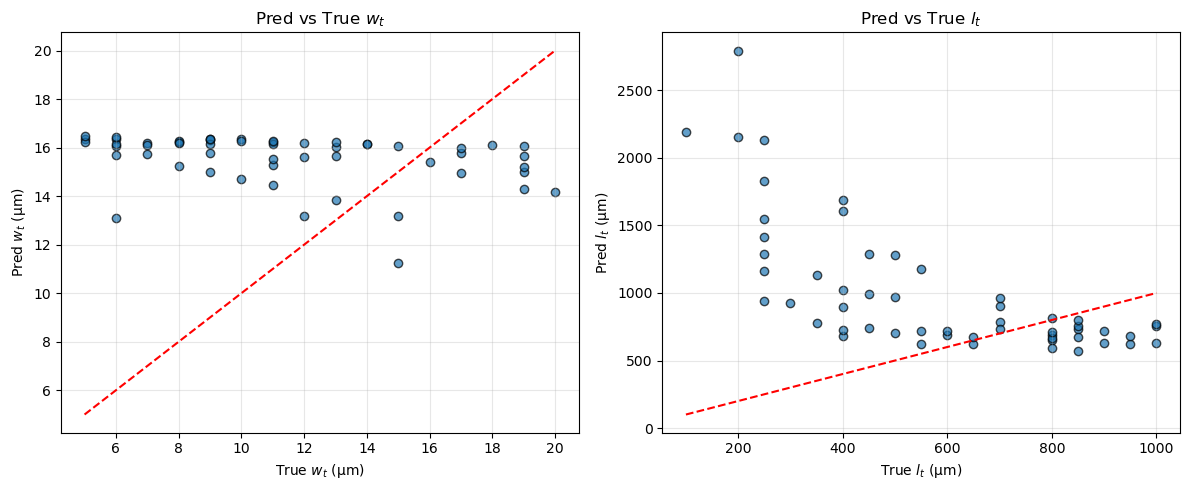

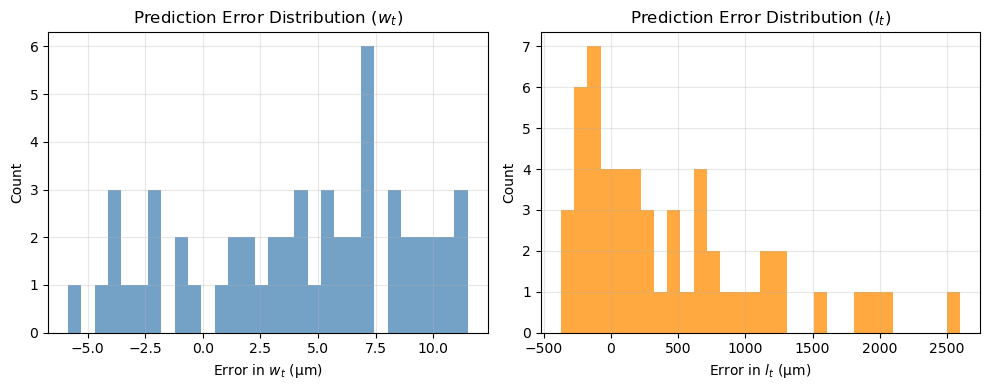

w_t  MAE: 5.538 μm | RMSE: 6.360 μm
l_t  MAE: 544.200 μm | RMSE: 802.582 μm


In [55]:
import numpy as np
import torch

def batch_predict(model, X_seq, X_center, scaler_wt, scaler_lt, batch_size=32, device='cpu'):
    model.eval()
    wt_pred, lt_pred = [], []
    with torch.no_grad():
        for i in range(0, len(X_seq), batch_size):
            batch_seq = [torch.tensor(X_seq[j], dtype=torch.float32) for j in range(i, min(i+batch_size, len(X_seq)))]
            batch_center = [torch.tensor(X_center[j], dtype=torch.float32) for j in range(i, min(i+batch_size, len(X_seq)))]
            x_seq_pad = torch.nn.utils.rnn.pad_sequence(batch_seq, batch_first=True, padding_value=0).to(device)
            x_center = torch.stack(batch_center).to(device)
            mask = (torch.sum(x_seq_pad, dim=2) == 0)
            y_pred = model(x_seq_pad, x_center, mask)
            # 反归一化到物理单位
            wt_pred_batch = scaler_wt.inverse_transform(y_pred[:,0:1].cpu().numpy()).flatten()
            lt_pred_batch = scaler_lt.inverse_transform(y_pred[:,1:2].cpu().numpy()).flatten()
            wt_pred.extend(wt_pred_batch)
            lt_pred.extend(lt_pred_batch)
    return np.array(wt_pred), np.array(lt_pred)

import matplotlib.pyplot as plt

# 测试集真实值（还原物理量，μm）
wt_true = scaler_wt.inverse_transform(Y_wt_te).flatten() * 1e6
lt_true = scaler_lt.inverse_transform(Y_lt_te).flatten() * 1e6

# 预测
wt_pred, lt_pred = batch_predict(model, Xte_seq, Xte_center, scaler_wt, scaler_lt, device=device)
wt_pred = wt_pred * 1e6  # 单位 μm
lt_pred = lt_pred * 1e6

# -- 1. 预测-真实 散点对比 --
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(wt_true, wt_pred, alpha=0.7, edgecolor='k')
plt.plot([wt_true.min(), wt_true.max()], [wt_true.min(), wt_true.max()], 'r--', lw=1.5)
plt.xlabel('True $w_t$ (μm)')
plt.ylabel('Pred $w_t$ (μm)')
plt.title('Pred vs True $w_t$')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(lt_true, lt_pred, alpha=0.7, edgecolor='k')
plt.plot([lt_true.min(), lt_true.max()], [lt_true.min(), lt_true.max()], 'r--', lw=1.5)
plt.xlabel('True $l_t$ (μm)')
plt.ylabel('Pred $l_t$ (μm)')
plt.title('Pred vs True $l_t$')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -- 2. 误差分布 --
wt_err = wt_pred - wt_true
lt_err = lt_pred - lt_true

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(wt_err, bins=30, color='steelblue', alpha=0.75)
plt.xlabel('Error in $w_t$ (μm)')
plt.ylabel('Count')
plt.title('Prediction Error Distribution ($w_t$)')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.hist(lt_err, bins=30, color='darkorange', alpha=0.75)
plt.xlabel('Error in $l_t$ (μm)')
plt.ylabel('Count')
plt.title('Prediction Error Distribution ($l_t$)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -- 3. 简单统计指标 --
print(f"w_t  MAE: {np.mean(np.abs(wt_err)):.3f} μm | RMSE: {np.sqrt(np.mean(wt_err**2)):.3f} μm")
print(f"l_t  MAE: {np.mean(np.abs(lt_err)):.3f} μm | RMSE: {np.sqrt(np.mean(lt_err**2)):.3f} μm")


In [ ]:
import matplotlib.pyplot as plt

epochs = len(history['train_loss'])

# 1. 总loss曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Total Loss')
plt.plot(range(1, epochs+1), history['val_loss'], label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('PINN Training/Validation Total Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/loss_curve_total_pde_driven_45.png', dpi=150)
plt.show()   # 显示在notebook

# 2. MSE、PDE子项loss曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), history['train_data'], label='Train MSE Loss')
plt.plot(range(1, epochs+1), history['val_data'], label='Val MSE Loss')
plt.plot(range(1, epochs+1), history['train_pde'], label='Train PDE Loss')
plt.plot(range(1, epochs+1), history['val_pde'], label='Val PDE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('PINN Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/loss_curve_components_pde_driven_45.png', dpi=150)
plt.show()   # 显示在notebook

# 2.PDE子项loss曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), history['train_pde'], label='Train PDE Loss')
plt.plot(range(1, epochs+1), history['val_pde'], label='Val PDE Loss')
plt.xlabel('Epoch')
plt.ylabel('PDE Loss')
plt.title('PINN PDE Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/loss_curve_pde_pde_driven_45.png', dpi=150)
plt.show()   # 显示在notebook


## 8. 模型保存与可视化结果导出

- 训练过程中最优模型自动保存至 `model/best_pinn_model.pt`
- 评估和所有可视化图片保存在 `results/` 文件夹，便于归档与后续分析


In [ ]:
# 1. 加载最佳模型参数
net.load_state_dict(torch.load('model/pde_driven_45.pt', map_location=device))
net.eval()

# ... 预测、计算误差等同前 ...

X_true = torch.from_numpy(Xte).to(device)
Y_true = torch.from_numpy(Yte).to(device)

with torch.no_grad():
    Q_pred_norm = net(X_true).cpu().numpy()
    Q_pred = st.inverse_transform(Q_pred_norm)
    Q_true = st.inverse_transform(Yte)
q_error = Q_pred.flatten() - Q_true.flatten()
# 2. 可视化保存
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(Q_true, Q_pred, alpha=0.6)
plt.plot([Q_true.min(), Q_true.max()], [Q_true.min(), Q_true.max()], 'r--')
plt.xlabel('True Q')
plt.ylabel('Predicted Q')
plt.title('PINN: Predicted vs True Q (Test Set)')
plt.grid(True)
plt.savefig('results/q_pred_vs_true_pde_driven_45.png', dpi=150)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(q_error, bins=30, alpha=0.7)
plt.xlabel('Q Prediction Error')
plt.ylabel('Count')
plt.title('Histogram of Q Prediction Error')
plt.grid(True)
plt.savefig('results/q_error_hist_pde_driven_45.png', dpi=150)
plt.show()

# 只展示前20条对照结果（可自定义n条）
n_display = 20
df_compare = pd.DataFrame({
    'True_Q': Q_true.flatten(),
    'Pred_Q': Q_pred.flatten(),
    'Error': (Q_pred - Q_true).flatten()
})

# 按误差绝对值降序排列，方便发现大误差
df_compare['AbsError'] = df_compare['Error'].abs()
df_compare_sorted = df_compare.sort_values(by='AbsError', ascending=False)

print("真实Q vs 预测Q（按绝对误差降序）前{}条：".format(n_display))
display(df_compare_sorted.head(n_display))

# 若要保存csv也很方便
df_compare_sorted.to_csv('results/q_true_pred_compare_pde_driven_45.csv', index=False)


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 图片文件路径（按顺序：data-driven, pde-driven，各三张，顺序为18、45、180）
img_paths = [
    'results/q_pred_vs_true_data_driven_18.png',
    'results/q_pred_vs_true_pde_driven_18.png',
    'results/q_pred_vs_true_data_driven_45.png',
    'results/q_pred_vs_true_pde_driven_45.png',
    'results/q_pred_vs_true_data_driven_180.png',
    'results/q_pred_vs_true_pde_driven_180.png',
]

# 行、列标签
row_labels = ['18', '45', '180']
col_labels = ['Data Driven', 'PDE Driven']

# 创建保存目录
os.makedirs('integrated_picture', exist_ok=True)

# 每个图宽:高 = 2:1，3行2列，整体宽:高 = 4:3，所以设置为12x9更合适
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        img = mpimg.imread(img_paths[i*2 + j])
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

for j, col in enumerate(col_labels):
    axes[0, j].set_title(col, fontsize=20, pad=15)

for i, row in enumerate(row_labels):
    ypos = [0.85, 0.52, 0.19][i]
    fig.text(0.01, ypos, row, va='center', ha='center', fontsize=16, fontweight='bold', rotation=0)

plt.tight_layout(rect=[0.045, 0, 1, 1])
plt.subplots_adjust(wspace=0.03, hspace=0.07)

save_path = 'integrated_picture/q_pred_vs_true_comparison.png'
plt.savefig(save_path, dpi=300)
plt.show()
print(f"按比例拼接完成，保存于：{save_path}")
